In [1]:
from project_lib import *
import itertools
import tqdm

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

In [3]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples',
                'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
                'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
                'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 100


SIGMA_WDW = 63
GAMMA = None

In [4]:
def run_bt_pipeline(TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            ):
    """
    Run BT pipeline
    """


    # list to store all trades
    trades_list = []
    trades_pnl = {}

    for security_id in tqdm.tqdm(TRADED_SECURITIES):
        # generate signal based on standard strategy
        signal_all = meanrev_signal(df[security_id],
                                    long_params = LONG_PARAMS,
                                    short_params = SHORT_PARAMS,
                                    ma_fast_wdw = MA_FAST_WDW,
                                    ma_slow_wdw = MA_SLOW_WDW
                    )
        
        # compute Historical Volatility
        hist_vol = df[security_id].pct_change().rolling(SIGMA_WDW).std() * np.sqrt(252)

        # "start your backtest at t-10". hard coding initial date for BT (and final date to avoid missing data)
        signal_all = signal_all.loc['2014-02-12':'2024-01-20']

        # extract from all signal only the actual open buy/sell triggers
        signal_do = signal_all[signal_all!= 0]

        # iterates over all buy/sell signal and execute orders
        for dt_open, direction in zip(signal_do.index, signal_do):
            
            # create a unique id for each trade
            trade_id = security_id+'#'+str(dt_open)[:10]

            # price at which the trade is open
            price_open = df.loc[dt_open, security_id]

            # compute TP/SL returns and prices
            tp_return, sl_return = tp_sl_rule(df[security_id],
                                                dt_open,
                                                direction,
                                                supportive_pctl_move = SUPPORTIVE_PCTL_MOVE,
                                                counter_pctl_move = COUNTER_PCTL_MOVE
                                            )
            price_tp = price_open * (1 + tp_return*direction)
            price_sl = price_open * (1 + sl_return*direction)

            if GAMMA == None:
                # compute the optimal sizing such that all trades loses the same amount of $ if SL is hitted
                quantity = MAX_DOLLAR_LOSS/((price_open - price_sl)*direction)
            else:
                quantity = MAX_DOLLAR_LOSS/((price_open - price_sl)*direction) * (GAMMA/hist_vol.loc[dt_open])

            # store all trade info in df
            trade = pd.DataFrame({'security_id':security_id,
                                    'dt_open':str(dt_open)[:10],
                                    'price_open':price_open,
                                    'direction':direction,
                                    'quantity':quantity,
                                    'price_tp':price_tp,
                                    'price_sl':price_sl}, index=[trade_id])

            # create a temporary df that contains prices of instrument during trade
            dt_open_idxdf = list(df.index).index(dt_open)
            temp_px = df[[security_id]].iloc[dt_open_idxdf + 1: dt_open_idxdf + TRADES_MAX_DAYS + 1]
            temp_px['price_open'] = price_open
            temp_px['direction'] = direction
            temp_px['quantity'] = quantity
            temp_px['price_tp'] = price_tp
            temp_px['price_sl'] = price_sl

            # Check if and when a TP/SL is triggered and cut the temporary df accordingly
            if direction==1:
                temp_px['tp_hitted'] = (temp_px[security_id] > temp_px['price_tp']) * 1
                temp_px['sl_hitted'] = (temp_px[security_id] < temp_px['price_sl']) * 1
            elif direction==-1:
                temp_px['tp_hitted'] = (temp_px[security_id] < temp_px['price_tp']) * 1
                temp_px['sl_hitted'] = (temp_px[security_id] > temp_px['price_sl']) * 1

            temp_px['tp_sl_hitted'] = temp_px['tp_hitted'] + temp_px['sl_hitted']

            if 1 in list(temp_px['tp_sl_hitted']):
                dt_close = str(temp_px[temp_px['tp_sl_hitted']==1].index[:1][0])[:10]
                exit_type = 'TP/SL exit'
            else:
                dt_close = str(list(temp_px.index)[-1:][0])[:10]
                exit_type = 'max duration'

            # cut temp_px at closing date
            temp_px = temp_px.loc[:dt_close]
            # compute PnL of the trade during the days it was open and append to Portfolio PnL list
            temp_px['pnl'] = temp_px[security_id] * temp_px['quantity']
            temp_px['daily_return'] = temp_px[security_id].pct_change().fillna(
                temp_px[security_id].iloc[0]/temp_px['price_open'].iloc[0]-1)

            # store closing price of the trade
            price_close = temp_px.loc[dt_close, security_id]

            # add closing trade date and price to trade df
            trade['dt_close'] = dt_close
            trade['price_close'] = price_close
            trade['duration'] = len(temp_px)
            trade['exit_condition'] = exit_type

            # compute the annualized volatility of the trade
            trade['ann_volatility'] = temp_px['daily_return'].std() * np.sqrt(252)

            # collect trade and pnl
            trades_list.append(trade)
            trades_pnl[trade_id] = temp_px

    # check if trades_list is non-empty
    if len(trades_list)==0:
        raise Exception('No trades have been executed')

    trades_list = pd.concat(trades_list)
    # compute trades' returns, sharpe 1Y and dollar value of position at each open
    trades_list['return'] = trade_return(trades_list)
    trades_list['daily_return'] = trades_list['return'] / trades_list['duration']
    trades_list['sharpe_ratio'] = trades_list['daily_return']*252 / trades_list['ann_volatility']

    # trim Sharpe ratio to reduce the impact of outliers on average measure
    trim_sharpe_up = trades_list['sharpe_ratio'].quantile(0.95)
    trim_sharpe_dwn = trades_list['sharpe_ratio'].quantile(0.05)
    trades_list['sharpe_ratio'] = trades_list['sharpe_ratio'].mask(trades_list['sharpe_ratio'] > trim_sharpe_up, trim_sharpe_up)
    trades_list['sharpe_ratio'] = trades_list['sharpe_ratio'].mask(trades_list['sharpe_ratio'] < trim_sharpe_dwn, trim_sharpe_dwn)

    # compute the dollar value postion at open and the pseudo-weight of the trade in the portfolio 
    trades_list['position_dollar_value_open'] = trades_list['quantity']*(
        trades_list['price_open']+trades_list['price_close'])/2
    trades_list['weight'] = (trades_list['position_dollar_value_open']*trades_list['duration']/
        (trades_list['position_dollar_value_open']*trades_list['duration']).sum())


    # split between TP and SL exit explicitly
    trades_list['exit_condition'] = trades_list['exit_condition'].mask(
        (trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']>0), 'TP exit')
    trades_list['exit_condition'] = trades_list['exit_condition'].mask(
        (trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']<0), 'SL exit')
    

    return trades_list, trades_pnl

In [5]:
trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

strategy_sharpe = (trades_list['sharpe_ratio']*trades_list['weight']).sum()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:46<00:00,  2.30s/it]


In [6]:
# Grid search for strategy optimal paramenters

GS_long_pctle = [{10:0.1, 21:0.2, 63:0.3},
                 {5:0.1, 10:0.2, 15:0.3},
                 {20:0.1, 40:0.2, 70:0.3}]

GS_short_pctle = [{10:1-0.1, 21:1-0.2, 63:1-0.3},
                 {5:1-0.1, 10:1-0.2, 15:1-0.3},
                 {20:1-0.1, 40:1-0.2, 70:1-0.3}]

GS_ma_fast = [10, 20, 30, 40]
GS_ma_slow = [50, 65, 80, 90]

# cartesian product of all parameters
GS_PARAMS = list(itertools.product(GS_long_pctle, GS_short_pctle, GS_ma_fast, GS_ma_slow))


sharpe_gs_ptf = {}
idx_gs = 0

for gsp in GS_PARAMS:
    trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
            gsp[0],
            gsp[1],
            gsp[2],
            gsp[3],
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )
    
    sharpe_gs_ptf[idx_gs] = (trades_list['sharpe_ratio']*trades_list['weight']).sum()
    idx_gs +=1
    print(idx_gs)


sharpe_gs_ptf = pd.DataFrame(sharpe_gs_ptf, index=['sharpe_gs']).T
sharpe_gs_ptf.to_csv(f'GS_Sharpe_{str(pd.Timestamp.now())[:16]}.csv')

100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


1


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


2


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


3


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


4


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


5


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


6


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


7


100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


8


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


9


100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


10


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


11


100%|██████████| 20/20 [00:49<00:00,  2.50s/it]


12


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


13


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


14


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


15


100%|██████████| 20/20 [07:43<00:00, 23.17s/it] 


16


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


17


100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


18


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


19


100%|██████████| 20/20 [00:59<00:00,  2.95s/it]


20


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


21


100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


22


100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


23


100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


24


100%|██████████| 20/20 [01:00<00:00,  3.05s/it]


25


100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


26


100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


27


100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


28


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


29


100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


30


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]


31


100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


32


100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


33


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


34


100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


35


100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


36


100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


37


100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


38


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


39


100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


40


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


41


100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


42


100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


43


100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


44


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


45


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


46


100%|██████████| 20/20 [01:03<00:00,  3.17s/it]


47


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


48


100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


49


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


50


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


51


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


52


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


53


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


54


100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


55


100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


56


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


57


100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


58


100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


59


100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


60


100%|██████████| 20/20 [01:01<00:00,  3.08s/it]


61


100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


62


100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


63


100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


64


100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


65


100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


66


100%|██████████| 20/20 [01:06<00:00,  3.31s/it]


67


100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


68


100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


69


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


70


100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


71


100%|██████████| 20/20 [01:05<00:00,  3.30s/it]


72


100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


73


100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


74


100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


75


100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


76


100%|██████████| 20/20 [01:18<00:00,  3.92s/it]


77


100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


78


100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


79


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


80


100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


81


100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


82


100%|██████████| 20/20 [01:06<00:00,  3.31s/it]


83


100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


84


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


85


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


86


100%|██████████| 20/20 [01:05<00:00,  3.27s/it]


87


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


88


100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


89


100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


90


100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


91


100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


92


100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


93


100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


94


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


95


100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


96


100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


97


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


98


100%|██████████| 20/20 [00:59<00:00,  3.00s/it]


99


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


100


100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


101


100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


102


100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


103


100%|██████████| 20/20 [01:02<00:00,  3.14s/it]


104


100%|██████████| 20/20 [00:59<00:00,  2.95s/it]


105


100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


106


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


107


100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


108


100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


109


100%|██████████| 20/20 [01:03<00:00,  3.17s/it]


110


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


111


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


112


100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


113


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


114


100%|██████████| 20/20 [01:05<00:00,  3.29s/it]


115


100%|██████████| 20/20 [01:05<00:00,  3.28s/it]


116


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


117


100%|██████████| 20/20 [01:05<00:00,  3.28s/it]


118


100%|██████████| 20/20 [01:05<00:00,  3.28s/it]


119


100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


120


100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


121


100%|██████████| 20/20 [01:05<00:00,  3.28s/it]


122


100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


123


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


124


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


125


100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


126


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


127


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


128


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


129


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


130


100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


131


100%|██████████| 20/20 [01:03<00:00,  3.19s/it]


132


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


133


100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


134


100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


135


100%|██████████| 20/20 [01:05<00:00,  3.25s/it]


136


100%|██████████| 20/20 [16:28<00:00, 49.44s/it]  


137


100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


138


100%|██████████| 20/20 [17:07<00:00, 51.35s/it] 


139


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


140


100%|██████████| 20/20 [16:26<00:00, 49.33s/it] 


141


100%|██████████| 20/20 [16:52<00:00, 50.60s/it] 


142


100%|██████████| 20/20 [16:10<00:00, 48.50s/it]  


143


100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


144


sharpe_gs    60
dtype: int64

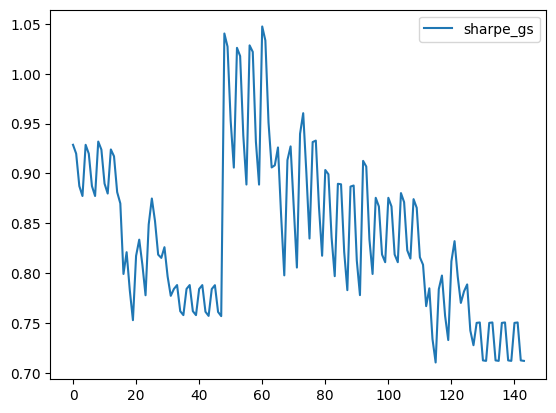

In [8]:
sharpe_gs_ptf.plot()
sharpe_gs_ptf.idxmax()

In [22]:
trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
            GS_PARAMS[4][0],
            GS_PARAMS[4][1],
            GS_PARAMS[4][2],
            GS_PARAMS[4][3],
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


In [32]:
trades_list.groupby('security_id').apply(lambda x: hit_ratio(x), include_groups=False).rename('hit_ratio').to_frame().join(
     trades_list.groupby('security_id').apply(lambda x: win_loss(x), include_groups=False).rename('win_loss').to_frame())

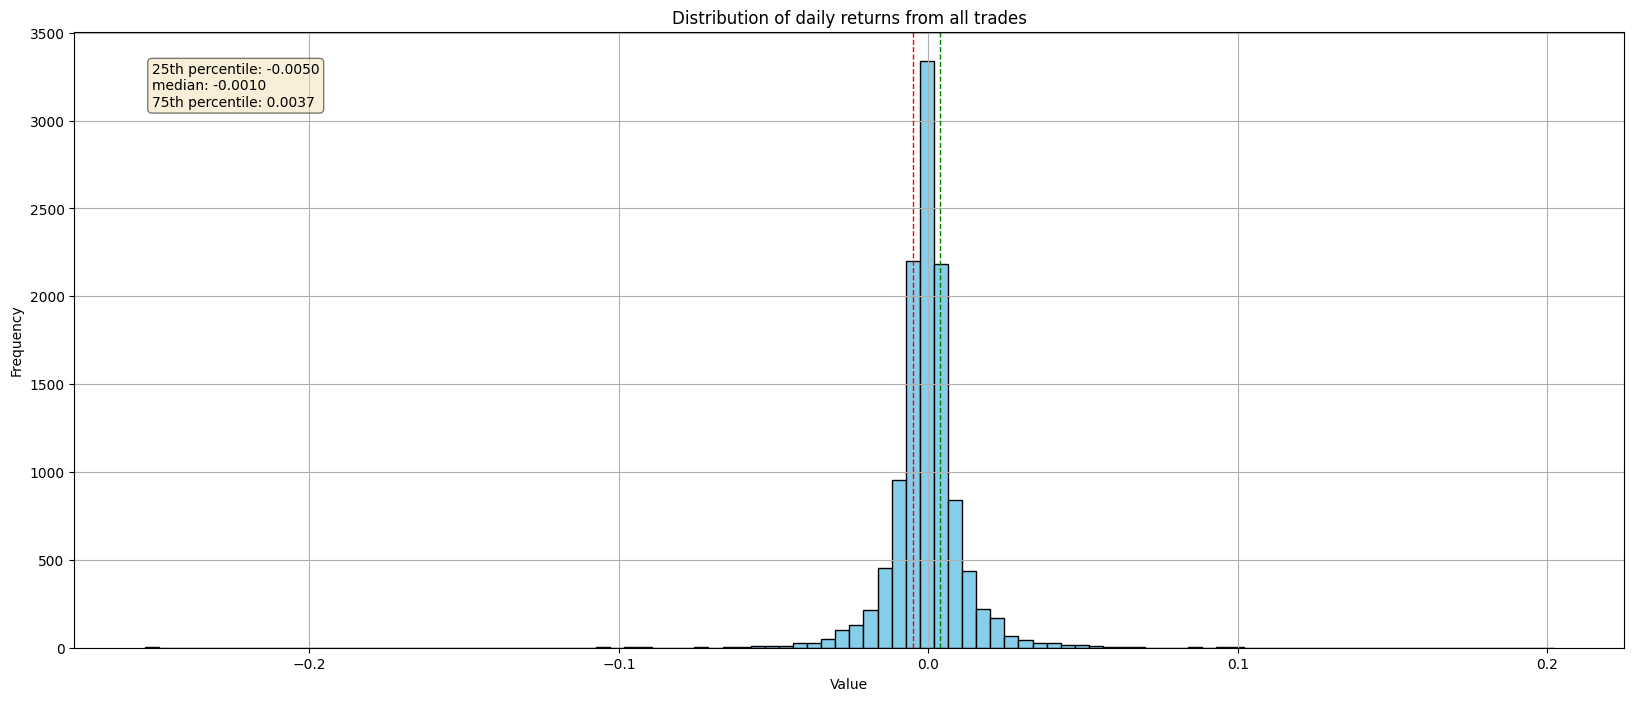

5th percentile: -0.0169


In [24]:
violin_plot_grouped(trades_list, 'security_id', 'daily_return')
violin_plot_grouped(trades_list.sort_values(by='duration'), 'duration', 'daily_return')
violin_plot_grouped(trades_list, 'direction', 'daily_return', figsize=(8,5))
plot_histogram(trades_list['daily_return'], 'Distribution of daily returns from all trades', figsize=(20, 8), bins=100)
trades_list.groupby('security_id')['daily_return'].describe()
print('5th percentile:', round(trades_list['daily_return'].quantile(0.05), 4))